In [1]:
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

df_ener_2019 = pd.read_csv('data/part-energies/xls/part-energies-2019.xls', sep='\t', encoding='latin-1', index_col=False, usecols=lambda x: x not in [' Stockage batterie', 'DÈstockage batterie', 'Eolien terrestre', 'Eolien offshore'])
df_ener_2020 = pd.read_csv('data/part-energies/xls/part-energies-2020.xls', sep='\t', encoding='latin-1', index_col=False,usecols=lambda x: x not in [' Stockage batterie', 'DÈstockage batterie', 'Eolien terrestre', 'Eolien offshore'])
df_ener_2021 = pd.read_csv('data/part-energies/xls/part-energies-2021-debut-2022.xls', sep='\t', encoding='latin-1', index_col=False,usecols=lambda x: x not in [' Stockage batterie', 'DÈstockage batterie', 'Eolien terrestre', 'Eolien offshore'])
df_ener_2022 = pd.read_csv('data/part-energies/xls/part-energies-fin-2022.xls', sep='\t', encoding='latin-1', index_col=False,usecols=lambda x: x not in [' Stockage batterie', 'DÈstockage batterie', 'Eolien terrestre', 'Eolien offshore'])

df_concat = pd.concat([df_ener_2019, df_ener_2020, df_ener_2021, df_ener_2022], ignore_index=True)
df_concat = df_concat.loc[(~df_concat['Consommation'].isnull())]
energies = ["Fioul","Charbon","Gaz","Nucléaire","Eolien","Solaire","Hydraulique","Bioénergies"]

/var/folders/4d/zt9y765s59xg9rkbzf15mwhc0000gn/T/ipykernel_45078/3945771555.py:8: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ener_2021 = pd.read_csv('data/part-energies/xls/part-energies-2021-debut-2022.xls', sep='\t', encoding='latin-1', index_col=False,usecols=lambda x: x not in [' Stockage batterie', 'DÈstockage batterie', 'Eolien terrestre', 'Eolien offshore'])
/var/folders/4d/zt9y765s59xg9rkbzf15mwhc0000gn/T/ipykernel_45078/3945771555.py:9: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ener_2022 = pd.read_csv('data/part-energies/xls/part-energies-fin-2022.xls', sep='\t', encoding='latin-1', index_col=False,usecols=lambda x: x not in [' Stockage batterie', 'DÈstockage batterie', 'Eolien terrestre', 'Eolien offshore'])


L'analyse du dataset n'est pas nécessaire étant donné que le graphique 7 utilise les mêmes données d'entée qui ont déjà fait l'objet d'une analyse.

In [2]:
df_concat.head()

,Périmètre,Nature,Date,Heures,Consommation,Prévision J-1,Prévision J,Fioul,Charbon,Gaz,...,Gaz - Cogén.,Gaz - CCG,Gaz - Autres,Hydraulique - Fil de l?eau + éclusée,Hydraulique - Lacs,Hydraulique - STEP turbinage,Bioénergies - Déchets,Bioénergies - Biomasse,Bioénergies - Biogaz,Déstockage batterie
0,France,Données définitives,2019-01-01,00:00,64207.0,64200.0,63800.0,146.0,11.0,3430.0,...,2482.0,832.0,112.0,3513.0,1080.0,1.0,555.0,322.0,295.0,ND
2,France,Données définitives,2019-01-01,00:30,63162.0,62700.0,62200.0,149.0,12.0,3029.0,...,2550.0,378.0,96.0,3454.0,1342.0,167.0,562.0,314.0,292.0,ND
4,France,Données définitives,2019-01-01,01:00,60923.0,60500.0,60200.0,149.0,12.0,2858.0,...,2566.0,191.0,98.0,3369.0,765.0,127.0,559.0,310.0,291.0,ND
6,France,Données définitives,2019-01-01,01:30,60729.0,61100.0,60900.0,147.0,10.0,2866.0,...,2567.0,200.0,95.0,3254.0,684.0,147.0,565.0,306.0,291.0,ND
8,France,Données définitives,2019-01-01,02:00,60127.0,60800.0,60400.0,146.0,13.0,2825.0,...,2564.0,162.0,94.0,3126.0,787.0,0.0,566.0,312.0,289.0,ND


In [3]:
# Feature engineering for energies

fioul_feats = ['Fioul', 'Fioul - TAC', 'Fioul - Cogén.', 'Fioul - Autres']
gaz_feats = ['Gaz', 'Gaz - TAC', 'Gaz - Cogén.', 'Gaz - CCG', 'Gaz - Autres']
hydrauliques_feats = ['Hydraulique', 'Hydraulique - Fil de l?eau + éclusée', 'Hydraulique - Lacs', 'Hydraulique - STEP turbinage']
bioenergies_feats = ['Bioénergies - Déchets', 'Bioénergies - Biomasse','Bioénergies - Biogaz', 'Bioénergies']
# Aggregating same feats that was in different columns
def sum_columns_values(df, columns, new_name):
    df_clean = df.copy()
    col = df.loc[:, columns].sum(axis=1)
    df_clean.drop(columns, axis=1, inplace=True)
    df_clean.insert(1, new_name, col)
    return df_clean

df_concat_cleaned = df_concat.copy()
df_concat_cleaned = sum_columns_values(df_concat_cleaned, fioul_feats, "Fioul")
df_concat_cleaned = sum_columns_values(df_concat_cleaned, gaz_feats, "Gaz")
df_concat_cleaned = sum_columns_values(df_concat_cleaned, hydrauliques_feats, "Hydraulique")
df_concat_cleaned = sum_columns_values(df_concat_cleaned, bioenergies_feats, "Bioénergies")
df_concat_cleaned.head()

/var/folders/4d/zt9y765s59xg9rkbzf15mwhc0000gn/T/ipykernel_45078/4181062871.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  col = df.loc[:, columns].sum(axis=1)


,Périmètre,Bioénergies,Hydraulique,Gaz,Fioul,Nature,Date,Heures,Consommation,Prévision J-1,...,Solaire,Pompage,Ech. physiques,Taux de Co2,Ech. comm. Angleterre,Ech. comm. Espagne,Ech. comm. Italie,Ech. comm. Suisse,Ech. comm. Allemagne-Belgique,Déstockage batterie
0,France,2344.0,9187.0,6856.0,273.0,Données définitives,2019-01-01,00:00,64207.0,64200.0,...,0.0,-1692.0,-545.0,25.0,-1555.0,-2400.0,456.0,-2288.0,3765.0,ND
2,France,2336.0,9926.0,6053.0,281.0,Données définitives,2019-01-01,00:30,63162.0,62700.0,...,0.0,-1506.0,-2581.0,23.0,-1555.0,-2400.0,456.0,-2288.0,3765.0,ND
4,France,2320.0,8522.0,5713.0,281.0,Données définitives,2019-01-01,01:00,60923.0,60500.0,...,0.0,-1507.0,-2740.0,22.0,-1555.0,-2400.0,709.0,-2353.0,3130.0,ND
6,France,2323.0,8170.0,5728.0,279.0,Données définitives,2019-01-01,01:30,60729.0,61100.0,...,0.0,-1662.0,-2860.0,22.0,-1555.0,-2400.0,709.0,-2353.0,3130.0,ND
8,France,2334.0,7826.0,5645.0,277.0,Données définitives,2019-01-01,02:00,60127.0,60800.0,...,0.0,-1745.0,-2789.0,22.0,-1506.0,-2400.0,52.0,-2336.0,3587.0,ND


In [4]:
dates = pd.to_datetime(df_concat['Date'] + df_concat['Heures'], format='%Y-%m-%d%H:%M')

df_finish = df_concat_cleaned.copy()
df_finish.insert(1, "FullDate", dates)
df_finish = df_finish.set_index('FullDate')
df_finish.columns

Index(['Périmètre', 'Bioénergies', 'Hydraulique', 'Gaz', 'Fioul', 'Nature',
       'Date', 'Heures', 'Consommation', 'Prévision J-1', 'Prévision J',
       'Charbon', 'Nucléaire', 'Eolien', 'Solaire', 'Pompage',
       'Ech. physiques', 'Taux de Co2', 'Ech. comm. Angleterre',
       'Ech. comm. Espagne', 'Ech. comm. Italie', 'Ech. comm. Suisse',
       'Ech. comm. Allemagne-Belgique', 'Déstockage batterie'],
      dtype='object')

In [5]:
# Getting only required features
energies.extend(['Date', 'Heures'])
df_finish = df_finish.loc[:, energies]

In [6]:
# Importing covid phases
covid_phases = [
    {
        'min': "2020-10-30",
        'max': "2020-11-28",
        'color': "red",
        'label': "Confinement total 1",
    },
    {
        'min': "2021-01-18",
        'max': "2021-01-18",
        'color': "green",
        'label': "Couvre feu 1",
    },
    {
        'min': "2021-03-20",
        'max': "2021-04-03",
        'color': "blue",
        'label': "Confinement partiel 1",
    },
    {
        'min': "2021-04-03",
        'max': "2021-06-09",
        'color': "red",
        'label': "Confinement total 2",
    },
    {
        'min': "2021-08-09",
        'max': "2021-08-09",
        'color': "green",
        'label': "Passe sanitaire",
    }
]

On va maintenant chercher à récupérer uniquement les données correspondantes à une des phases du covid précedemment définies.

In [7]:
# Getting selected phase related rows by date
def get_rows_by_date_range(df, date_range):
    phase_1 = df.copy()
    phase_1 = phase_1.loc[((df_finish['Date'] >= date_range['min']) & (df_finish['Date'] <= date_range['max']))]
    return phase_1

date_range = covid_phases[0]
phase_1 = get_rows_by_date_range(df_finish, date_range)
phase_1

,Fioul,Charbon,Gaz,Nucléaire,Eolien,Solaire,Hydraulique,Bioénergies,Date,Heures
FullDate,,,,,,,,,,
2020-10-30 00:00:00,162.0,6.0,2506.0,39253.0,8083.0,1.0,13467.0,2171.0,2020-10-30,00:00
2020-10-30 00:30:00,162.0,6.0,1827.0,39093.0,8037.0,1.0,13833.0,2181.0,2020-10-30,00:30
2020-10-30 01:00:00,162.0,6.0,1523.0,38360.0,7883.0,0.0,13532.0,2169.0,2020-10-30,01:00
2020-10-30 01:30:00,162.0,6.0,1606.0,38791.0,7646.0,0.0,12894.0,2162.0,2020-10-30,01:30
2020-10-30 02:00:00,161.0,7.0,1576.0,38608.0,7508.0,0.0,12670.0,2171.0,2020-10-30,02:00
...,...,...,...,...,...,...,...,...,...,...
2020-11-28 21:30:00,168.0,381.0,15980.0,45964.0,5511.0,1.0,8463.0,2293.0,2020-11-28,21:30
2020-11-28 22:00:00,168.0,365.0,15313.0,45629.0,5373.0,1.0,8400.0,2284.0,2020-11-28,22:00
2020-11-28 22:30:00,168.0,339.0,15149.0,45580.0,5077.0,1.0,8390.0,2244.0,2020-11-28,22:30


Puis aller récupérer pour les mêmes dates mais d'une année antérieure ou postérieure.

In [8]:
def change_year_string(date_string, number_year_add):
    date_string_split = date_string.split('-')
    year_int = int(date_string_split[0]) + number_year_add
    date_string_split[0] = str(year_int)
    return "-".join(date_string_split)

In [9]:
# Getting selected phase related rows by date
def get_df_moved_year(move_year_by, base_df_date_range):
    phase_2_range = base_df_date_range.copy()
    phase_2_range['min'] = change_year_string(phase_2_range['min'] ,move_year_by)
    phase_2_range['max'] = change_year_string(phase_2_range['max'] ,move_year_by)

    phase_2 = df_finish.copy()
    phase_2 = phase_2.loc[((df_finish['Date'] >= phase_2_range['min']) & (df_finish['Date'] <= phase_2_range['max']))]
    return phase_2

phase_2 = get_df_moved_year(1, date_range)
phase_2

,Fioul,Charbon,Gaz,Nucléaire,Eolien,Solaire,Hydraulique,Bioénergies,Date,Heures
FullDate,,,,,,,,,,
2021-10-30 00:00:00,168.0,1004.0,3824.0,41423.0,5553.0,1.0,6917.0,2429.0,2021-10-30,00:00
2021-10-30 00:30:00,167.0,964.0,3510.0,41760.0,5776.0,1.0,7073.0,2432.0,2021-10-30,00:30
2021-10-30 01:00:00,169.0,704.0,2879.0,40893.0,6089.0,1.0,5954.0,2406.0,2021-10-30,01:00
2021-10-30 01:30:00,167.0,484.0,2306.0,40927.0,6227.0,1.0,4962.0,2451.0,2021-10-30,01:30
2021-10-30 02:00:00,166.0,232.0,1647.0,40720.0,6473.0,1.0,4594.0,2460.0,2021-10-30,02:00
...,...,...,...,...,...,...,...,...,...,...
2021-11-28 21:30:00,183.0,118.0,14676.0,42795.0,5433.0,0.0,9658.0,2287.0,2021-11-28,21:30
2021-11-28 22:00:00,184.0,144.0,14290.0,42595.0,5307.0,0.0,7839.0,2286.0,2021-11-28,22:00
2021-11-28 22:30:00,190.0,143.0,13923.0,42395.0,4962.0,0.0,7714.0,2273.0,2021-11-28,22:30


Après avoir récupéré nos deux datasets, il faut aller comparer l'évolution des données entre les différentes années.

In [10]:
# Compute evolution percentage between each values of 2 dataframes

def process_evolution_percentage(df1,df2):
    sub = df2.reset_index().select_dtypes('number').subtract(df1.reset_index().select_dtypes('number'), axis=0)
    div = sub.divide(phase_1.reset_index().select_dtypes('number'), axis=0)
    return div.loc[~div['Fioul'].isnull()] *100

div = process_evolution_percentage(phase_1, phase_2)

Afin de mieux visualiser à quoi correspond chaque point de l'axe des abscisses, on génère une chaine de caractère qui va remplacer les labels de chacun de ces points avec les dates comparées.

In [11]:
# Formatting x-axis ticks labels
def generate_xticks_labels(df1, df2):
    phase_1_indexes = df1.index.strftime('%Y-%m-%d %H:%M:%S').tolist()
    phase_1_indexes = [s + " et " for s in phase_1_indexes]
    phase_2_indexes = df2.index.strftime('%Y-%m-%d %H:%M:%S').tolist()
    x_axis_labels = list(map(str.__add__, phase_1_indexes, phase_2_indexes))
    return x_axis_labels

x_axis_labels = generate_xticks_labels(phase_1, phase_2)
final_data = div.loc[~div['Fioul'].isnull()] *100
final_data.index = x_axis_labels

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '2020-10-30 00:00:00 et 2021-10-30 00:00:00'),
  Text(0.2, 0, ''),
  Text(0.4, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, ''),
  Text(1.0, 0, '2020-10-30 00:30:00 et 2021-10-30 00:30:00')])

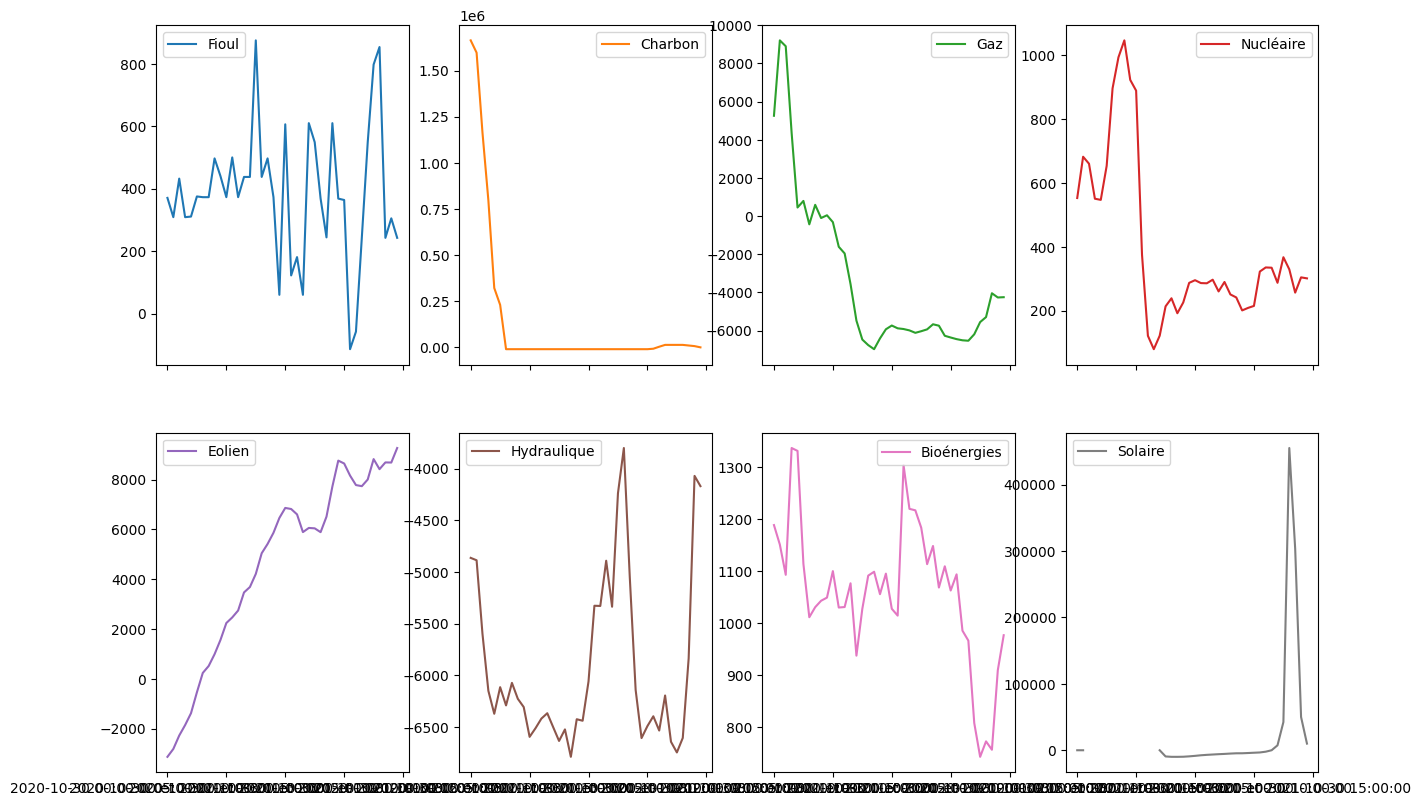

In [12]:
# Plotting
energies_2 = ["Fioul","Charbon","Gaz","Nucléaire","Eolien","Hydraulique","Bioénergies","Solaire"]
final_data.loc[:, energies_2].head(40).plot(subplots=True, figsize=(15, 15), layout=(3, 4))
plt.xticks(rotation = 90) 

Les données semblent compliquées à lire. Pour résoudre ce problème nous allons convertir la valeur d'énergie produite (en MW) par chaque filière par sa part en pourcentage parmi toute la production.

In [15]:
# converting phase_1 & phase_2 to percentage per timestamp
def get_percentages(row):
    total = int(row.sum(axis=1).values[0])
    return row.applymap(lambda p: p/total)

phase_1_percentage = get_percentages(phase_1.loc[:, energies_2])
phase_2_percentage = get_percentages(phase_2.loc[:, energies_2])

div_percentage = process_evolution_percentage(phase_1_percentage, phase_2_percentage)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

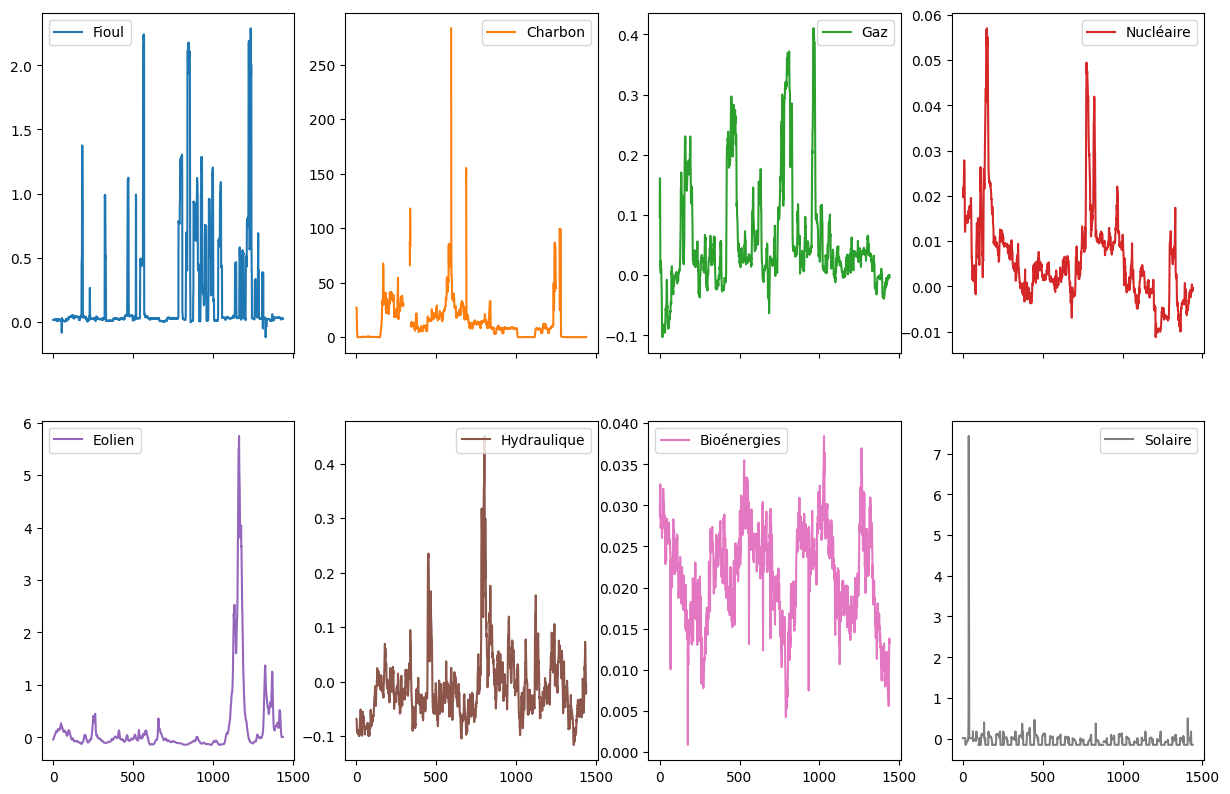

In [16]:
# Plotting
final_data_percentage = div_percentage.loc[~div['Fioul'].isnull()] *100
final_data_percentage.loc[:, energies_2].plot(subplots=True, figsize=(15, 15), layout=(3, 4))
plt.xticks(rotation = 90) 

D'une année à l'autre, ici novembre 2021 par rapport à novembre 2020, on remarque bien pour certaines filières une tendance. Par exemple, la part de production des bioénergies semble augmenter légèrement entre la période covid et la période non covid.